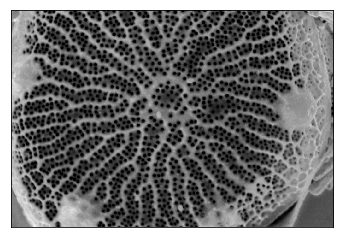

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.morphology import skeletonize, remove_small_objects

#cropping the image, h-77 subtracts the title at the bottom
original_img = cv2.imread('Wild052.tif',0)
(h,w)=np.shape(original_img)
img = original_img[0:h-77, 0:w]
plt.imshow(img, cmap = 'gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

#equalizing the histogram
equ = cv2.equalizeHist(img)

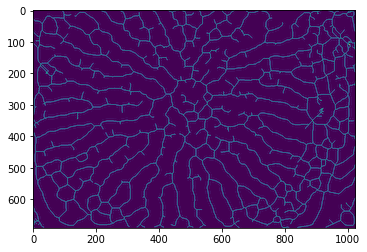

In [8]:
#This sction blurs, thresholds, and skeletonizes the image
#It uses an average blur and an adaptive (local) mean threshold
#Remove_small_objects gets rid of any unconnected dots or lines
ablur = cv2.blur(equ,(17, 17))
a_mthres = cv2.adaptiveThreshold(ablur,1,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,45,4) 
adaptiveskeleton = skeletonize(a_mthres)
cleanskel=remove_small_objects(adaptiveskeleton, min_size=70, connectivity=3)
plt.imshow(cleanskel,interpolation='sinc') 

In [9]:
#the original image values (integers) become floats
#Dividing by 255 normalizes the floats; now they are all between 0 and 1
floatimg=img.astype(float)
normimg=floatimg/255

#This makes the skeleton into a RGB image with the dimensions of the cropped diatom image
floatskel=cleanskel.astype(float)
(x,y)=np.shape(img)
rgbpic=np.zeros((x,y,3))

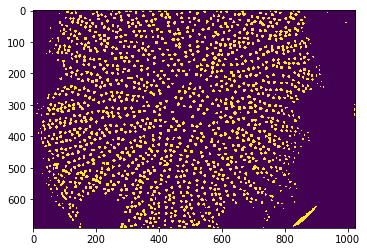

In [11]:
dots=1-(normimg>0.1)
plt.imshow(dots)

In [ ]:
##this may work but probably not

float_dots=dots.astype(float)
nDotCenter = 1
while (nDotCenter>0):
    #blur the skeleton with 3x3; this gives the average value in a 3x3 portion of the skeleton
    # 9 times the average - 1 should be the number of neighbors
    dotblur = cv2.blur(float_dots,(3,3))
    dotneighbors=((9*dotblur))*floatskel

    
    #removing the end pixel if a skeleton pixel has 1 neighbor
    dot_center = ((dotneighbors<9)==0)
    float_dot_center = dot_center.astype(float)
    float_dots=float_dots-float_dot_center
    nDotCenter=np.sum(dot_center)
plt.imshow(dot_center, interpolation='sinc')

In [12]:
# this section finds the number of neighbors to each point in the skeleton
# line ends are points that have only one neighbor
# we want to get rid of these
# keep looping over this section until the number of line ends equals zero
nLineEnds = 1
while (nLineEnds>0):
    #blur the skeleton with 3x3; this gives the average value in a 3x3 portion of the skeleton
    # 9 times the average - 1 should be the number of neighbors
    skelblur = cv2.blur(floatskel,(3,3))
    neighbors=((9*skelblur)-1)

    #making sure edges always have values
    edges=np.zeros((x,y))
    a=15
    edges[0:a,:]=np.ones((a,y))
    edges[x-a:x,:]=np.ones((a,y))
    edges[:,0:a]=np.ones((x,a))
    edges[:,y-a:y]=np.ones((x,a))
    
    #removing the end pixel if a skeleton pixel has 1 neighbor
    neighbors=(neighbors+5*edges)*floatskel
    line_ends = (neighbors==1)
    float_line_ends = line_ends.astype(float)
    floatskel=floatskel-line_ends
    nLineEnds=np.sum(line_ends)
#plt.imshow(neighbors, interpolation='sinc')

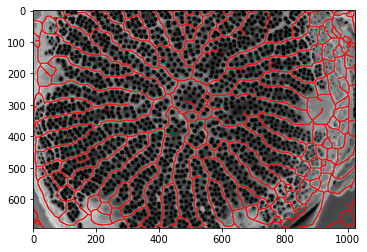

In [13]:
#dilating the lines of the skeleton to a 3x3 square of pixels
kernel=np.ones((3,3))
skel_dilation=cv2.dilate(floatskel,kernel,iterations=1)

#defining r, g, and b values for the overlay
rgbpic[:,:,0]=skel_dilation*(1-normimg)+normimg
rgbpic[:,:,1]=(1-skel_dilation)*normimg
rgbpic[:,:,2]=(1-skel_dilation)*normimg

#plotting the overlay
plt.imshow(rgbpic, interpolation='sinc')